## Learning How to Use fastjet
Resources:
- https://fastjet.readthedocs.io/en/latest/Awkward.html#
- https://github.com/scikit-hep/fastjet/blob/main/README.md
- https://github.com/SUEPPhysics/SUEPCoffea_dask

In [1]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

### Setting up basic plot
This is the original way I set it up. I believe this is incorrect.

In [11]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

no_muons = events.PandoraPFOs[muonsevent != True]

There is a specfic e+e- kt algorithm however it doesn't seem to work when called. Call is `fastjet.JetDefinition(ee_fastjet.kt_algorithm,0.4)`. There is also `ee_genkt_algorithm` which for $R>2$ and $p=1$ gives ee_kt apparantly. These are probably what we're going to use, I just need to work with them more to figure out what they actually want when called.

In [5]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,0.2) # right now defined with R = 0.4

In [12]:
cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=2)

In [13]:
fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets_constituent_index(njets=2).compute()

<Array [[[59], [65]], ..., [[90, ...], ...]] type='3424 * var * var * int32'>

In [16]:
np.max(ak.num(events.PandoraPFOs.compute()))

157

In [7]:
# this sets up the jets using Coffea

jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
CPU times: user 10.2 s, sys: 2.27 s, total: 12.5 s
Wall time: 13.3 s


{'from-uproot-ae83a185ebc8d961f8ed54855ba9951a': ['PandoraPFOs.x',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.charge',
  'PandoraPFOs.z',
  'PandoraPFOs.y',
  'PandoraPFOs.t']}

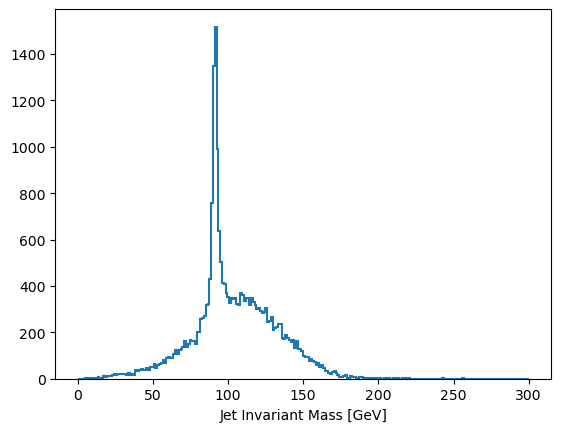

In [8]:
%%time
# energy of the filtered jets
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


energy_hist_clusters = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

energy_hist_clusters.compute().plot1d(label='Jets')
dak.necessary_columns(energy_hist_clusters)

### Comparing $R$ Values

CPU times: user 1min 26s, sys: 7.25 s, total: 1min 34s
Wall time: 2min 10s


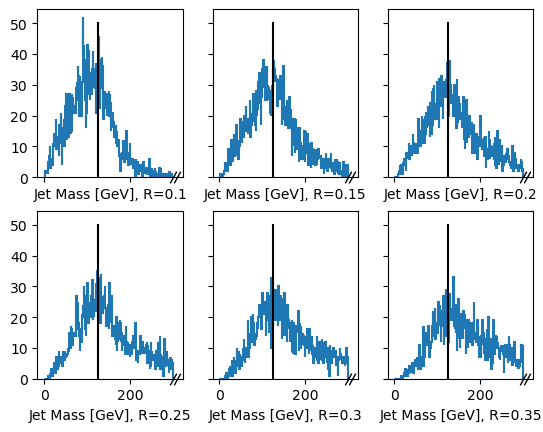

In [8]:
%%time
fig,axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
k = 6
R = [0.1,0.15,0.2,0.25,0.3,0.35]

for n in range(k):
    jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,R[n])
    
    cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=2)
    
    jets = dak.zip(
        {
            'x': cluster["px"],
            'y': cluster["py"],
            'z': cluster["pz"],
            't': cluster["E"],
        },
        with_name="LorentzVector",
        behavior=events.PandoraPFOs.behavior,
    )
    
    jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


    energy_hist_clusters = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet Mass [GeV], R={R[n]}") 
        .Double()
        .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
    )
#     print((axs.flatten()[n]))
    energy_hist_clusters.compute().plot1d(label=f'R = {R[n]}',ax=axs.flatten()[n])
    dak.necessary_columns(energy_hist_clusters)
    

    axs.flatten()[n].plot([125,125],[0,50],'black')

### Taking more than 2 jets and then take the invariant mass of the leading two (the two jets with the highest pt) 

CPU times: user 33.3 s, sys: 2.76 s, total: 36 s
Wall time: 33.8 s


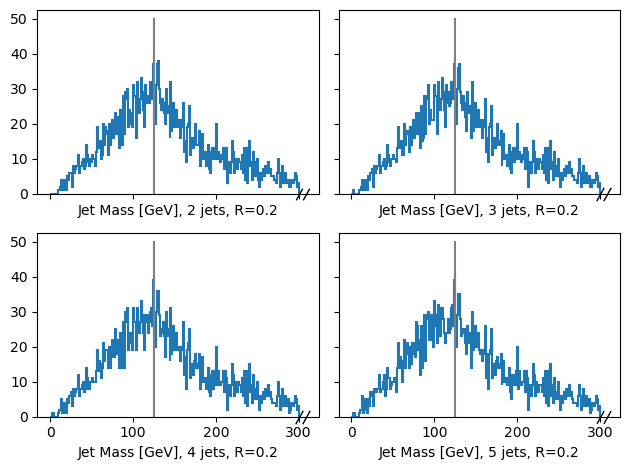

In [19]:
%%time
fig,axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
R = 0.2

for n in range(4):
    jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,R)
    
    cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=n+2)
    
    jets = dak.zip(
        {
            'x': cluster["px"],
            'y': cluster["py"],
            'z': cluster["pz"],
            't': cluster["E"],
        },
        with_name="LorentzVector",
        behavior=events.PandoraPFOs.behavior,
    )
    
    jetpairs = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs
    
    jetpair = jetpairs[dak.singletons(dak.argmax(jetpairs.jet1.pt+jetpairs.jet2.pt,axis=1))] # two jets with highest momentum
    

    energy_hist_clusters = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet Mass [GeV], {n+2} jets, R={R}") 
        .Double()
        .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
    )

    energy_hist_clusters.compute().plot1d(label=f'num jets = {n+2}',ax=axs.flatten()[n])
    dak.necessary_columns(energy_hist_clusters)
    
    plt.tight_layout()

    axs.flatten()[n].plot([125,125],[0,50],'gray')

CPU times: user 34.2 s, sys: 3.76 s, total: 38 s
Wall time: 37.3 s


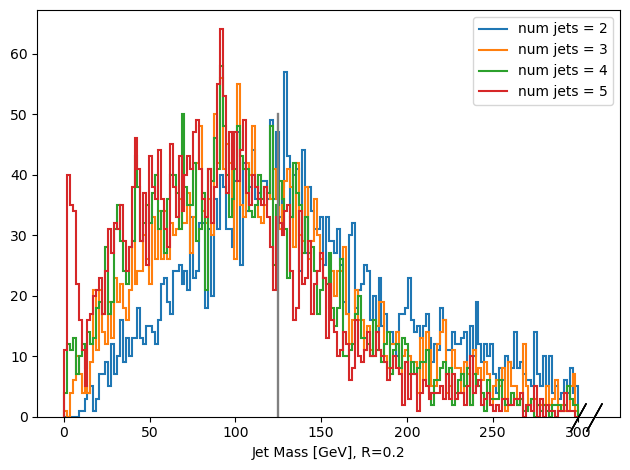

In [30]:
%%time
fig,axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
R = 0.2

for n in range(4):
    jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,R)
    
    cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=n+2)
    
    jets = dak.zip(
        {
            'x': cluster["px"],
            'y': cluster["py"],
            'z': cluster["pz"],
            't': cluster["E"],
        },
        with_name="LorentzVector",
        behavior=events.PandoraPFOs.behavior,
    )
    
    jetpairs = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs
    
    jetpair = jetpairs[dak.singletons(dak.argmin(jetpairs.jet1.pt+jetpairs.jet2.pt,axis=1))] # two jets with highest momentum
    

    energy_hist_clusters = (
        hda.Hist.new.Reg(175, 0, 300, name="energy", label=f"Jet Mass [GeV], R={R}") 
        .Double()
        .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
    )

    energy_hist_clusters.compute().plot1d(label=f'num jets = {n+2}')
    dak.necessary_columns(energy_hist_clusters)
    
    plt.tight_layout()

    plt.plot([125,125],[0,50],'gray')
    plt.legend()

#### plot of momentum for each of four jets

CPU times: user 47.6 s, sys: 4.9 s, total: 52.5 s
Wall time: 1min 5s


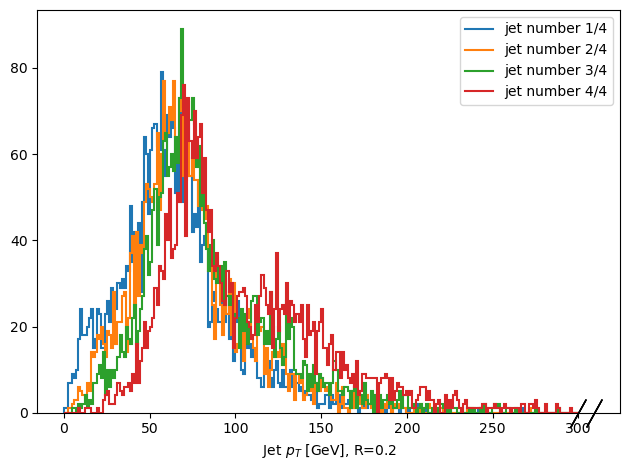

In [24]:
%%time
# fig,axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
R = 0.2

mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

# bit of a sketchy way of masking but it works and is quick so that's what I'm doing for now!
truth_arr = dak.ones_like(dak.num(events.PandoraPFOs)) == dak.ones_like(dak.num(events.PandoraPFOs)) 
no_muons = events.PandoraPFOs[muonsevent != truth_arr]

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,R)

cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=4)
    
jets4 = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)    

for n in range(4):
    hist_jet_p = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet $p_T$ [GeV], R={R}") 
        .Double()
        .fill(jets4[...,n].pt)
    )

    hist_jet_p.compute().plot1d(label=f'jet number {n+1}/4')
    dak.necessary_columns(hist_jet_p)
    
    plt.tight_layout()

    plt.legend()

#### the case with only 2 jets

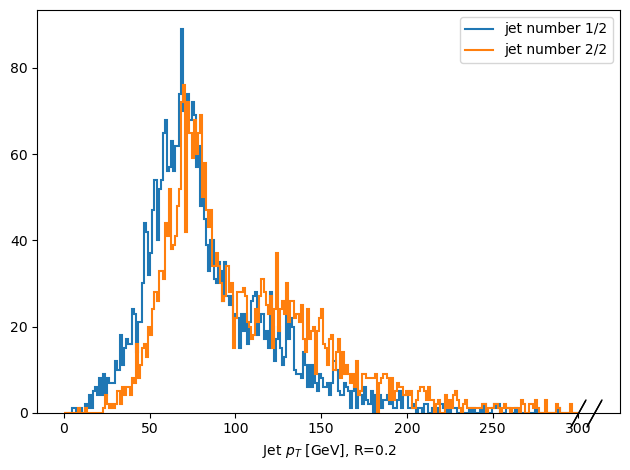

In [25]:
cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=2)
    
jets2 = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)    

for n in range(2):
    hist_jet_p = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet $p_T$ [GeV], R={R}") 
        .Double()
        .fill(jets2[...,n].pt)
    )

    hist_jet_p.compute().plot1d(label=f'jet number {n+1}/2')
    dak.necessary_columns(hist_jet_p)
    
    plt.tight_layout()

    plt.legend()

Plot the two jets with the highest momentum overlaid from the two above graphs. Make two plots side by side with both on top of each other.

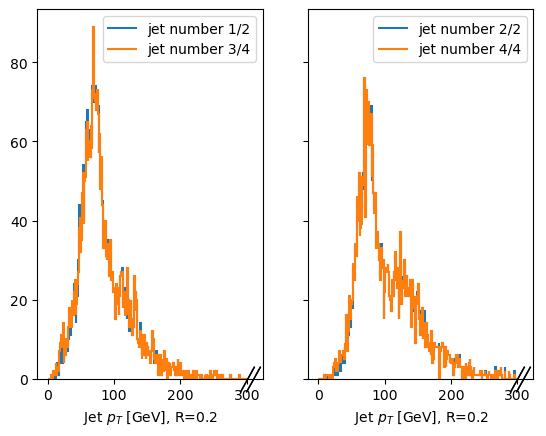

In [30]:
fig,axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

for n in range(2):
    hist_jet_p_2 = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet $p_T$ [GeV], R={R}") 
        .Double()
        .fill(jets2[...,1-n].pt)
    )
    
    hist_jet_p_4 = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet $p_T$ [GeV], R={R}") 
        .Double()
        .fill(jets4[...,3-n].pt)
    )

    hist_jet_p_2.compute().plot1d(label=f'jet number {1-n+1}/2',ax=axs[1-n])
    dak.necessary_columns(hist_jet_p_2)
    
    hist_jet_p_4.compute().plot1d(label=f'jet number {3-n+1}/4',ax=axs[1-n])
    dak.necessary_columns(hist_jet_p_4)
    
#     plt.tight_layout()

    axs[1-n].legend()

### Trying to link jets to gen particles (Correct Set-up)
Seems to be working with awkward but dask-awkward is less happy with some. 

**Note: dask arrays are indexed with dask arrays**

Still pretty messy...

In [33]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)


# bit of a sketchy way of masking but it works and is quick so that's what I'm doing for now!
truth_arr = dak.ones_like(dak.num(events.PandoraPFOs)) == dak.ones_like(dak.num(events.PandoraPFOs)) 

There is a specfic e+e- kt algorithm however it doesn't seem to work when called. Call is `fastjet.JetDefinition(ee_fastjet.kt_algorithm,0.4)`. There is also `ee_genkt_algorithm` which for $R>2$ and $p=1$ gives ee_kt apparantly. These are probably what we're going to use, I just need to work with them more to figure out what they actually want when called.

In [49]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1) # right now defined with R = 0.4

In [50]:
cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2)

In [51]:
no_muons = cluster[muonsevent != truth_arr] # slicing has to happen after for exclusive_jets_constituent_index

In [52]:
# this sets up the jets using Coffea

jets = dak.zip(
    {
        'x': no_muons["px"],
        'y': no_muons["py"],
        'z': no_muons["pz"],
        't': no_muons["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

CPU times: user 9.25 s, sys: 913 ms, total: 10.2 s
Wall time: 10.4 s


{'from-uproot-192274911838efd2ad125ad463826135': ['PandoraPFOs.t',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.y',
  'PandoraPFOs.charge',
  'PandoraPFOs.x',
  'PandoraPFOs.z']}

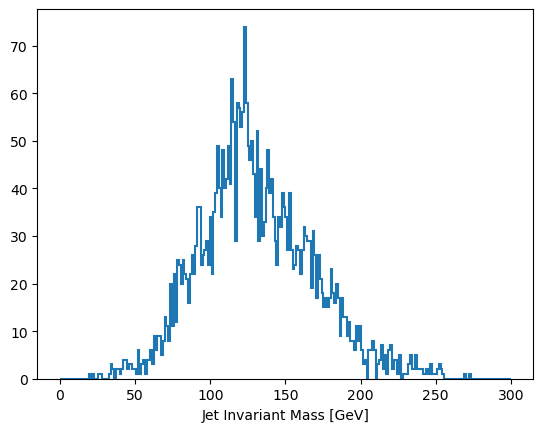

In [53]:
%%time
# energy of the filtered jets
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


energy_hist_clusters = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

energy_hist_clusters.compute().plot1d(label='Jets')
dak.necessary_columns(energy_hist_clusters)

#### Seeing what particles go into each jet 
I have to do most of this with awkward since there is no option for local_index in dak :(

In [56]:
reco_index = fastjet.ClusterSequence(arr, jetdef).exclusive_jets_constituent_index(njets=2).compute()

Number of reco particles that go into each jet:

In [57]:
ak.num(reco_index,axis=2)

<Array [[2, 23], [2, 2], ..., [1, ...], [13, 23]] type='28200 * var * int64'>

In [155]:
ak.flatten(reco_index,axis=2)

<Array [[20, 59, 1, 2, 3, ..., 54, 55, 56, 57], ...] type='28200 * var * int32'>

In [58]:
jet1_slices = ak.flatten(reco_index,axis=1)[ak.local_index(ak.flatten(reco_index,axis=1),axis=0) % 2 == 0]

In [63]:
j = dak.from_awkward(jet1_slices,npartitions=3)

In [69]:
matched_pdg = events.PandoraPFOs.matched_gen.pdgId.compute()[jet1_slices][muonsevent.compute() != truth_arr.compute()]


In [151]:
values, counts = np.unique(ak.flatten(ak.flatten(matched_pdg,axis=2),axis=1),return_counts=True)

In [152]:
values[counts == np.max(counts)]

<Array [22] type='1 * int64'>

In [118]:
event_max = np.max(np.max(abs(matched_pdg),axis=1),axis=1)

In [141]:
np.unique(event_max[np.where(event_max > 3500)])

<Array [1000010020, 1000010030, ..., 1000120260, 1000130270] type='9 * ?int32'>

https://twiki.cern.ch/twiki/pub/Geant4/ExtendingFnalDb/Nuclei.txt

In [153]:
! pdgid 22

γ


'hi'

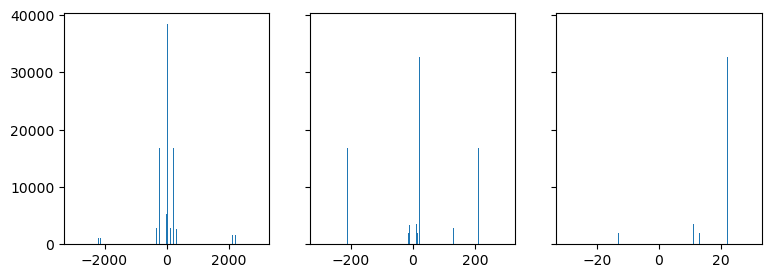

In [108]:
# make subplots with different ranges!! 


fig,axs = plt.subplots(1,3,sharey=True, figsize=(9, 3))
# ax.hist(ak.flatten(ak.flatten(matched_pdg,axis=2),axis=1),range=(-30,30),bins=200)
axs[0].hist(ak.flatten(ak.flatten(matched_pdg,axis=2),axis=1),range=(-3000,3000),bins=200)
axs[1].hist(ak.flatten(ak.flatten(matched_pdg,axis=2),axis=1),range=(-300,300),bins=200)
axs[2].hist(ak.flatten(ak.flatten(matched_pdg,axis=2),axis=1),range=(-30,30),bins=200)

# for n in range(len(axs)): plt.xlabel('pdgId',ax=axs[n])

CPU times: user 1min 14s, sys: 3.9 s, total: 1min 18s
Wall time: 1min 15s


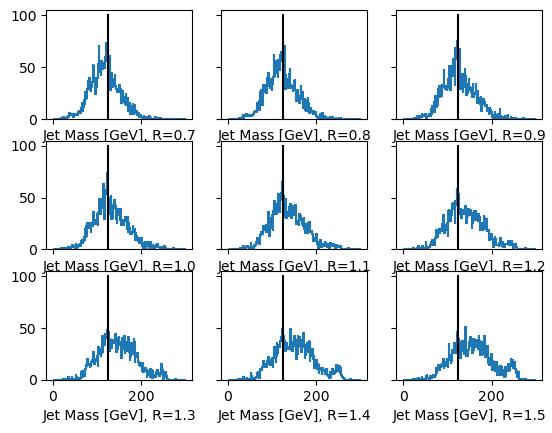

In [68]:
%%time
fig,axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
R = [0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
k = len(R)

for n in range(k):
    jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,R[n])
    
    cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2)  
    no_muons = cluster[muonsevent != truth_arr]
    
    jets = dak.zip(
        {
            'x': no_muons["px"],
            'y': no_muons["py"],
            'z': no_muons["pz"],
            't': no_muons["E"],
        },
        with_name="LorentzVector",
        behavior=events.PandoraPFOs.behavior,
    )
    
    jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


    energy_hist_clusters = (
        hda.Hist.new.Reg(250, 0, 300, name="energy", label=f"Jet Mass [GeV], R={R[n]}") 
        .Double()
        .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
    )
#     print((axs.flatten()[n]))
    energy_hist_clusters.compute().plot1d(label=f'R = {R[n]}',ax=axs.flatten()[n])
    dak.necessary_columns(energy_hist_clusters)
    

    axs.flatten()[n].plot([125,125],[0,100],'black')

### Problems from before:

In [ ]:
# selecting the events I want 
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

select_pfos = events.PandoraPFOs[muonsevent]
# select_pfos = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs.pdgId) == 13) != True]


# running this through fastjet and setting up with coffea

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
cluster = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)

jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

In [ ]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


hist_clusters_2 = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_clusters_2.compute().plot1d(label='Jets')
dak.necessary_columns(hist_clusters_2)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

In [ ]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2).compute() # showing example

In [ ]:
dak.num(select_pfos).compute() # should be the max index 

(also there are two functions and `exclusive_jets_consituents_index()` does not work)

Constituents not being able to be returned either:

In [ ]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituents(njets=2).compute()

### Including Muons
The plan is to make 4 jets, where two are supposedly muons, and then discount the two that are closest to the muons in angle space.

{'from-uproot-e0cd8aa9cd32adc67bda28c8199b2827': ['PandoraPFOs.charge',
  'PandoraPFOs.x',
  'PandoraPFOs.y',
  'PandoraPFOs.t',
  'PandoraPFOs.z',
  'PandoraPFOs.pdgId']}

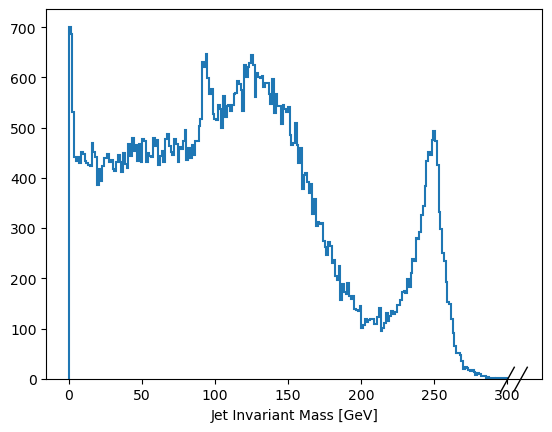

In [14]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,2) # define jets with kt algorithm with R=1
# cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).inclusive_jets() # create jets
cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=4) # create jets


mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

select_clst = cluster[muonsevent]

jets = dak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 


hist_jets = (
    hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

In [ ]:
%%time
for n in range(28200):
    print(n)
    try:
        cluster = fastjet.ClusterSequence(events.PandoraPFOs.compute()[n], jetdef).exclusive_jets(n_jets=4)
    except:
        print(f'{n} failed')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27